In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openmm
from openmm import unit
from openmm import CustomExternalForce

%matplotlib inline

In [2]:
# define relevant variables

radius_negative = 105.0 #nanometers
radius_positive = 95.0 #nanometers
box_length = 1000.0 #nanometers
particle_mass = 1 #amu
particle_density = 1.05 #g/cm^3
water_density = 0.998 #g/cm^3
g = 9.8 #m/s^2

density_difference = particle_density - water_density
mass_negative = (density_difference * 4/3*np.pi * radius_negative**3)

In [12]:
# write a numpy function to compute gravitational force

def expected_gravitational_potential(z, g, particle_mass):
    
    energy_conversion_factor = 10**36 #divide by 10^36 to convert to energy unit of kJ
    
    return (g * particle_mass * z /energy_conversion_factor) 

In [4]:
# write numpy function to compute gravitational force in openmm syntax

def get_potentials(z_positions, g, radius_negative, particle_density, water_density, box_length, platform_name="Reference"):
    
    # Set up system.
    system = openmm.System()
    
    g = g * unit.meter/unit.second**2
    box_length = box_length * unit.nanometer # default distance is nanometers 
    radius_negative = radius_negative * unit.nanometer
    particle_density = particle_density * unit.gram / unit.centimeter**3
    water_density = water_density * unit.gram / unit.centimeter**3
    
    pi = np.pi

    system.setDefaultPeriodicBoxVectors([box_length, 0.0, 0.0],
                                        [0.0, box_length, 0.0],
                                        [0.0, 0.0, box_length])
    
    u_grav = CustomExternalForce(
                "(g * particle_mass * z);"
                "density_difference = particle_density - water_density;"
                "particle_mass = (particle_density - water_density) * 4/3 * pi * radius_negative^3;"
            )


    u_grav.addGlobalParameter("g", g)
    u_grav.addGlobalParameter("pi", pi)
    u_grav.addGlobalParameter("particle_density", particle_density)
    u_grav.addGlobalParameter("water_density", water_density)
    u_grav.addGlobalParameter("radius_negative", radius_negative)
    
     # Add forces.
    system.addForce(u_grav)
    
    # Add a particle to the system 
    system.addParticle(mass=1.0)
    u_grav.addParticle(0)
    
    for force in system.getForces():
            print(f"Energy function: {force.getEnergyFunction()}")
            #print(f"Nonbonded method: {force.getNonbondedMethod()}, Cutoff distance: {force.getCutoffDistance()}")
            #assert force.usesPeriodicBoundaryConditions()
            #assert not force.getUseLongRangeCorrection()

    # Set up platform and context. The platform_name is typically Reference or CUDA.
    platform = openmm.Platform.getPlatformByName(platform_name)
    temperature = 298.0 * unit.kelvin
    dummy_integrator = openmm.LangevinIntegrator(
        temperature.value_in_unit(unit.kelvin), 0.0, 0.0)
    context = openmm.Context(system, dummy_integrator, platform)
    print(f"Using {context.getPlatform().getName()} platform.")
    if context.getPlatform().getName() == "CUDA":
        for cuda_property in ("Precision", "TempDirectory", "UseCpuPme", "DeviceIndex", "UseBlockingSync", "DeterministicForces"):
            print(f"{cuda_property}: {context.getPlatform().getPropertyValue(context, cuda_property)}")
    
    potential_energies = np.zeros(len(z_positions))
    for z_index, z_pos in enumerate(z_positions):

        context.setPositions([[0, 0, z_pos]])
        state = context.getState(getEnergy=True)
        
        potential_energies[z_index] = (
            state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)
            #/ (unit.BOLTZMANN_CONSTANT_kB * temperature * unit.AVOGADRO_CONSTANT_NA)
        )
    
    return potential_energies

In [5]:
z_positions = np.linspace(-box_length / 2 + 100, box_length / 2 - 100, num=1000)

potential_vals = get_potentials(z_positions, g, radius_negative, particle_density, water_density, box_length, platform_name="Reference")

Energy function: (g * particle_mass * z);density_difference = particle_density - water_density;particle_mass = (particle_density - water_density) * 4/3 * pi * radius_negative^3;
Using Reference platform.


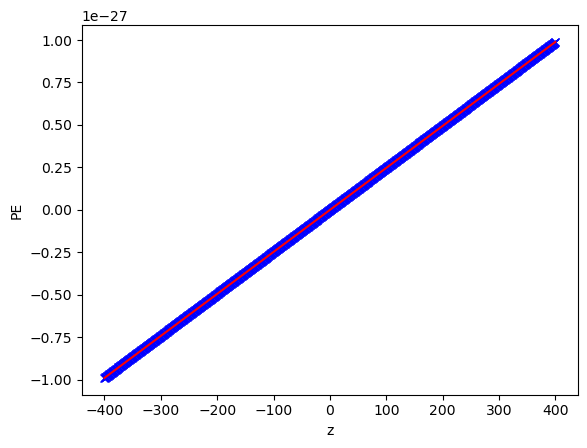

In [14]:
z_positions_exp = np.linspace(-box_length / 2 + 100, box_length / 2 - 100, num=1000)
pots_negative = expected_gravitational_potential(z_positions_exp, g, mass_negative)
#pots_positive = gravitational_potential(z_positions_exp, density_difference, radius_positive)

#plt.plot(z_positions_exp, pots_positive, color="k")
plt.plot(z_positions, potential_vals, color='blue', marker="x")
plt.plot(z_positions_exp, pots_negative, color="r")

plt.xlabel("z")
plt.ylabel("PE")

plt.show()